## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Camera calibration using chessboard images

#### Examine calibration images

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

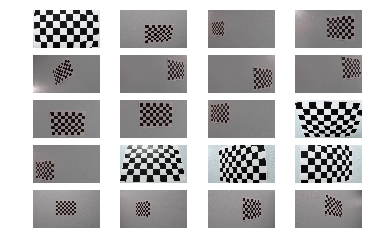

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

images = glob.glob('./camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    plt.subplot(5,len(images)//5,idx+1)
    plt.axis('off')
    plt.imshow(img)


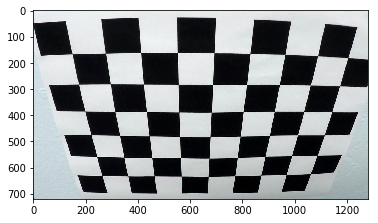

In [3]:
plt.imshow(cv2.imread(images[11]))

*Notice there are 6x9 inner corners which will be used as object points*

In [4]:
# prepare object points, like (0,0,0), (1,0,0), ..., (8,0,0),(0,1,0),(0,2,0),....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape((-1,2)) #pythonian magic to make (x,y,0) coordinate array

# Arrays to store object points and image points from all the images.
objPoints = [] # 3d points in real world space
imgPoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    found, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if found:
        objPoints.append(objp)
        imgPoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, found)
        cv2.imshow('img',img)
        cv2.waitKey(100)

cv2.destroyAllWindows()

In [5]:
print(len(images))
print(len(objPoints))
print(len(imgPoints))

20
17
17


## Use image points and object points from previous step to calibrate camera

In [6]:
import pickle

def calibrate(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = img
    if len(gray.shape) == 3:
        gray = cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
    return  cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) #[::-1] == reverse 


mtx = None
dist = None
try:
    with open("camera_matrix.pa", "rb") as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
except:
    img = cv2.imread("./camera_cal/calibration3.jpg")
    ret, mtx, dist, rvecs, tvecs = calibrate(img,objPoints,imgPoints)

    file_Name = "camera_matrix.p"
    with open(file_Name,'wb') as f:
        pickle.dump({"mtx":mtx,"dist":dist},f)   

### Use camera matrix and distortion matrix to unwarp corners

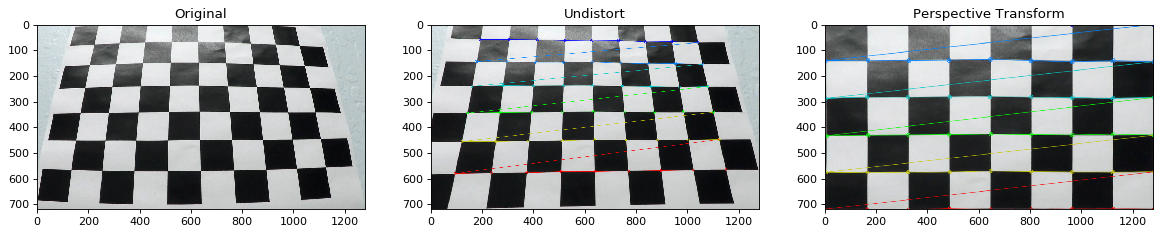

In [7]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    found, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if found:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, found)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 0 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                     [img_size[0]-offset, img_size[1]-offset],
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, undist


img = cv2.imread("./camera_cal/calibration3.jpg")
warped, perspective_Mtx, undist = corners_unwarp(img, 9, 6, mtx, dist)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,3,1)
ax.set_title("Original")
plt.imshow(img)

ax = plt.subplot(1,3,2)
ax.set_title("Undistort")
plt.imshow(undist)

ax = plt.subplot(1,3,3)
ax.set_title("Perspective Transform")
plt.imshow(warped)


## 2. Apply a distortion correction to raw images


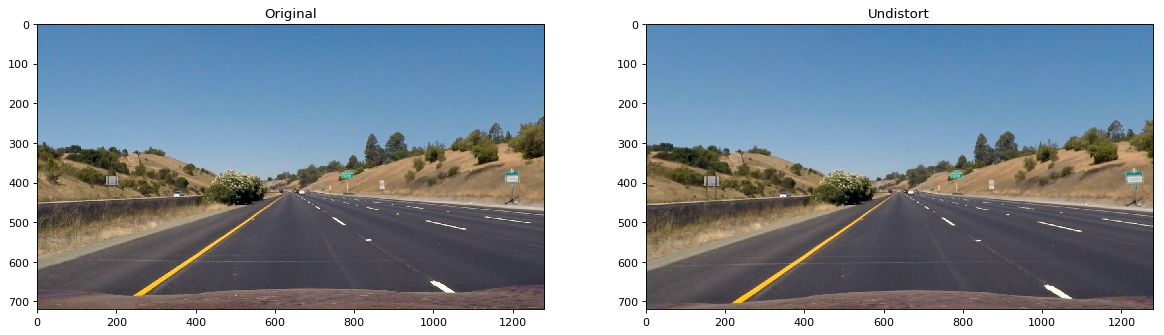

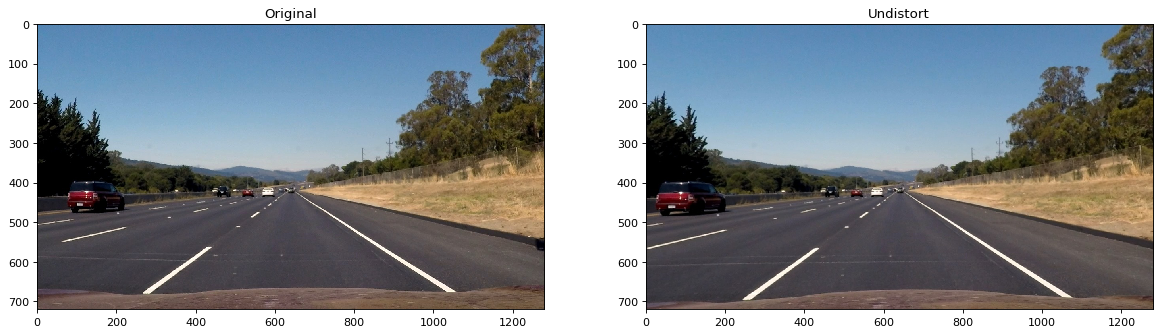

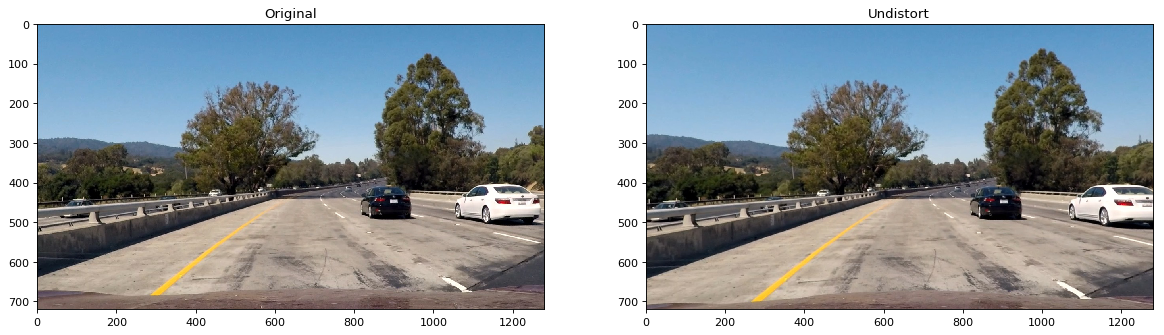

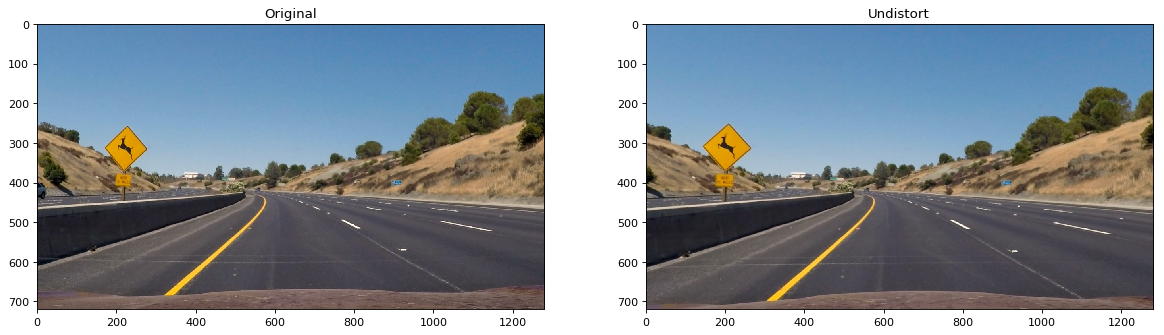

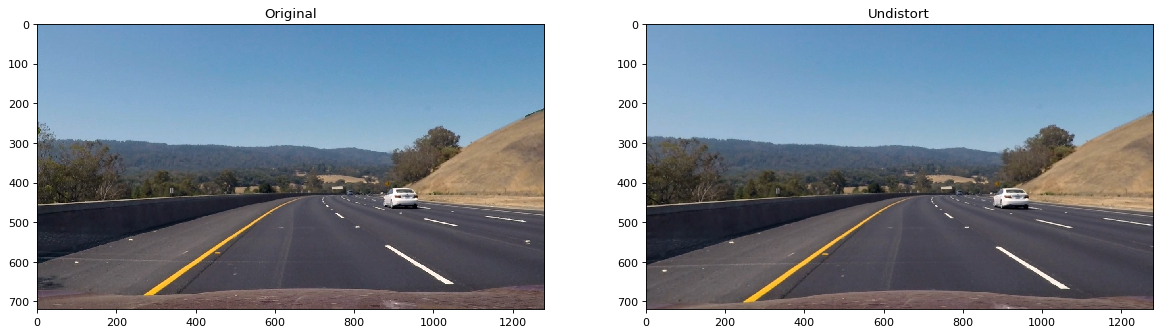

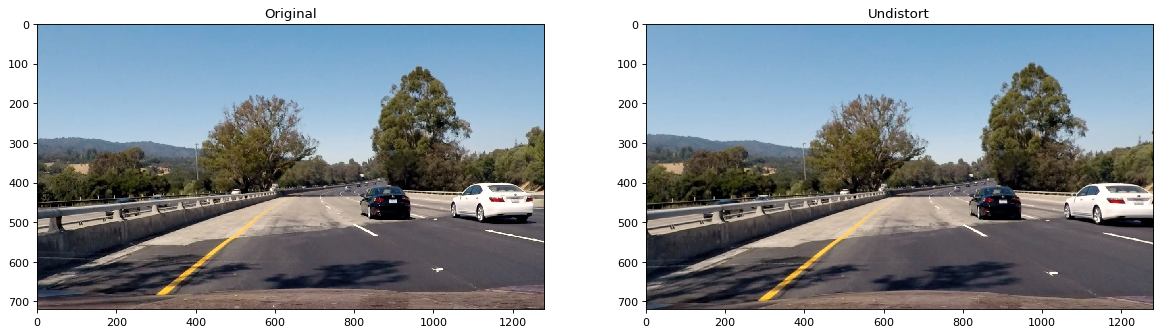

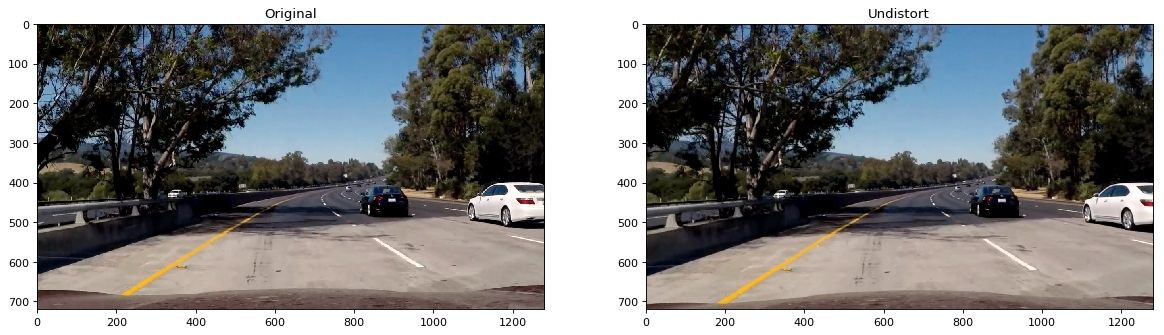

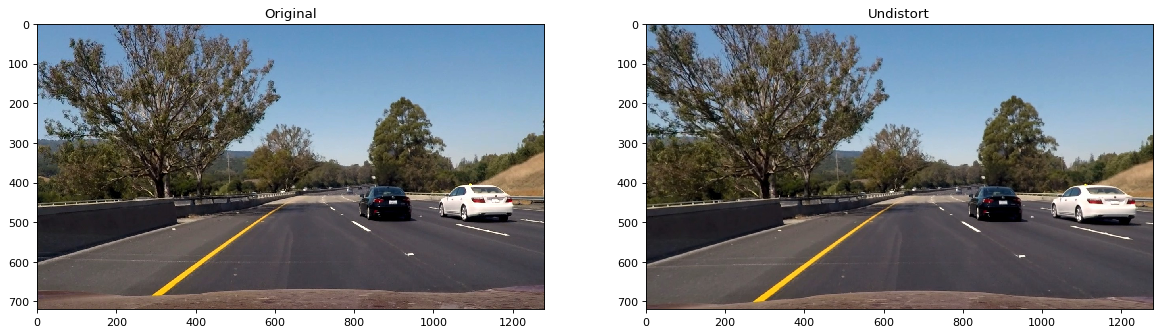

In [8]:
images = glob.glob('./test_images/*.jpg')

for f_name in images:
    img = plt.imread(f_name)
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(1,2,1)
    ax.set_title("Original")
    plt.imshow(img,)

    ax = plt.subplot(1,2,2)
    ax.set_title("Undistort")
    plt.imshow(undist)


## 3. Create a Thresholded Binary Image

HLS color space is used here because it can handle different lightning condition

In [184]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, ksize=3, inverse=False):
    
    gray = img
    if(len(img.shape) == 3):
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    sorbeled = None
    filler = None
    op = None
    if inverse:
        filler = 0
        op = np.ones_like
    else:
        filler = 1
        op = np.zeros_like

    ksize = 31 if ksize > 31 else ksize # max at 31
    if orient == 'x':
        sorbeled = np.sqrt(np.square(np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = ksize))))
    else:
        sorbeled = np.sqrt(np.square(np.abs(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = ksize))))

    # scale to 255 max
    sorbeled = np.uint8((sorbeled / np.max(sorbeled)) * 255)

    binary_output = op(sorbeled)
    binary_output[(sorbeled >= thresh_min) & (sorbeled <= thresh_max)] = filler

    return binary_output


def mag_thresh(img, thresh_min=0,thresh_max=255,ksize=3):

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ksize = 31 if ksize > 31 else ksize # max at 31
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # scale to 255 max
    gradmag = np.uint8((gradmag / np.max(gradmag)) * 255)

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return binary_output


def color_thresh(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    b = img[:,:,0]
    g = img[:,:,1]
    r = img[:,:,2]
    
    binary = np.zeros_like(S)
    binary[( ((S > 90) & (S <= 255) & (H >70) & (H < 109)) | (r > 200) )] = 1
    return binary
    
def getTopMask(img):
    
    height,width,_ = img.shape
    ones = np.ones((720//2)*1280)
    zeros = np.zeros((height-(720//2))*1280)
    return np.concatenate((ones,zeros)).reshape((height,width))


def binaryThresholded(img):
    
    thX = abs_sobel_thresh(img,orient='x',thresh_min=15,thresh_max=70,ksize=5)
    colored = color_thresh(img)
    result = np.zeros_like(thX)
    mask = getTopMask(img)
    
    result[( ((colored==1) | (thX == 1)) & (mask!=1) )] = 1
    return result


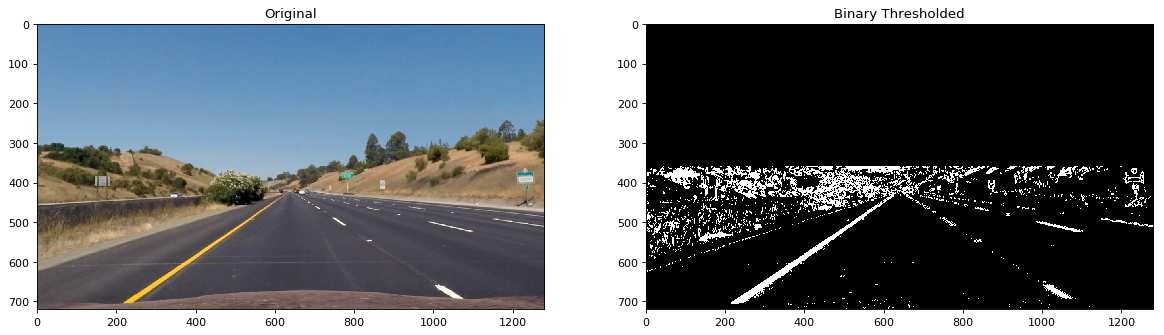

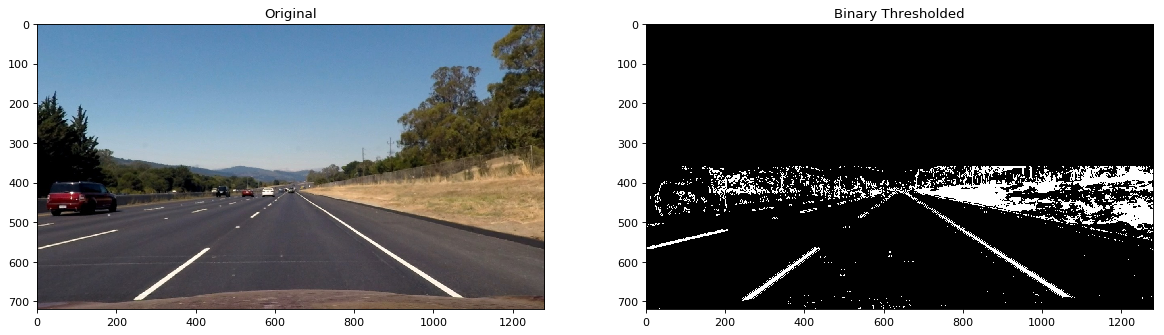

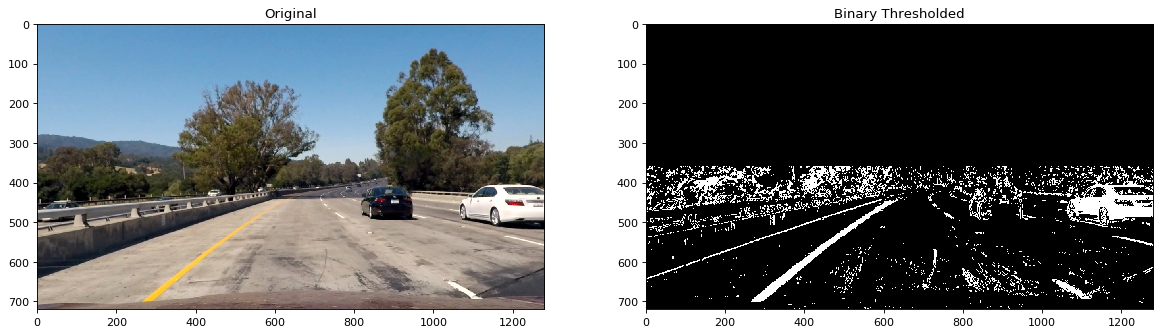

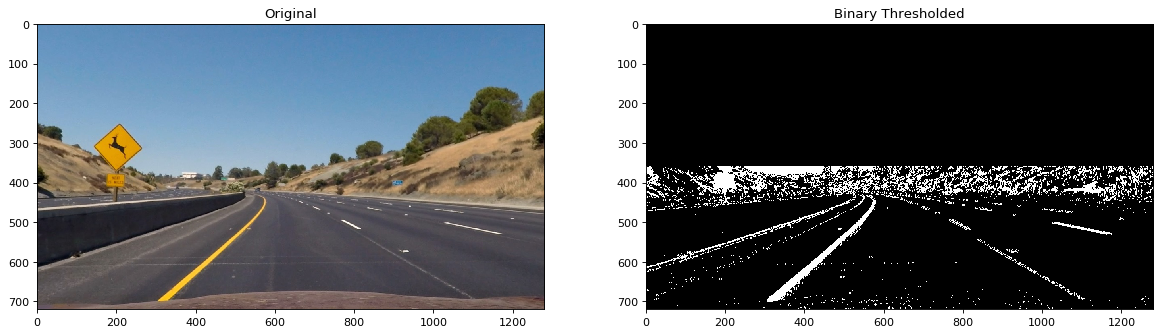

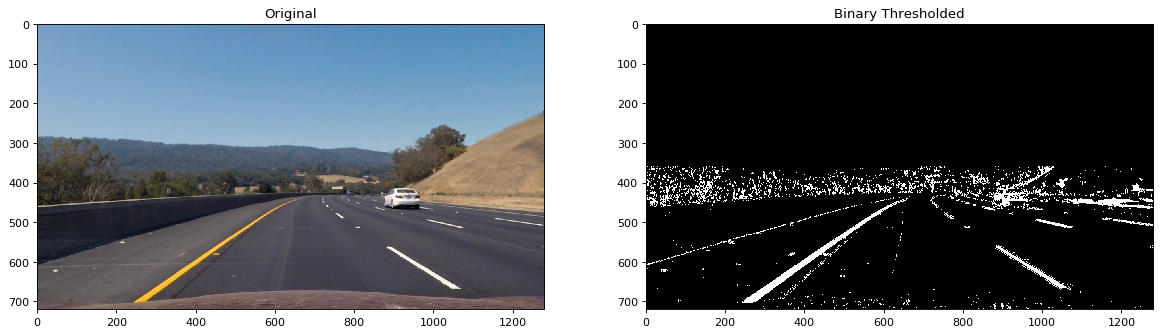

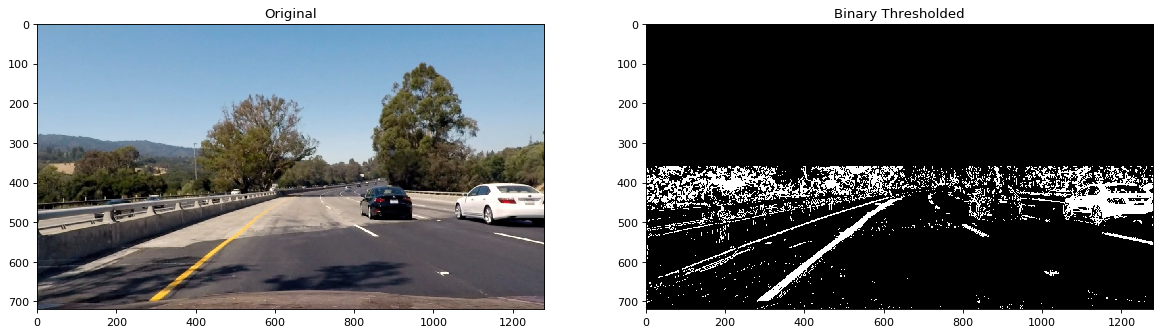

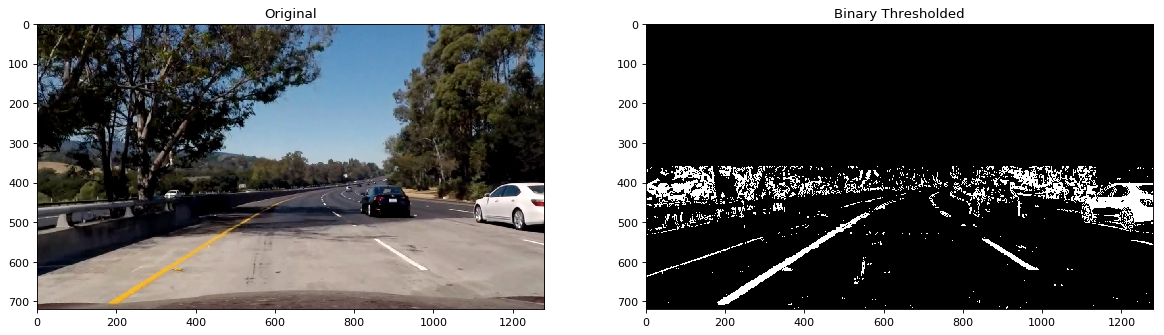

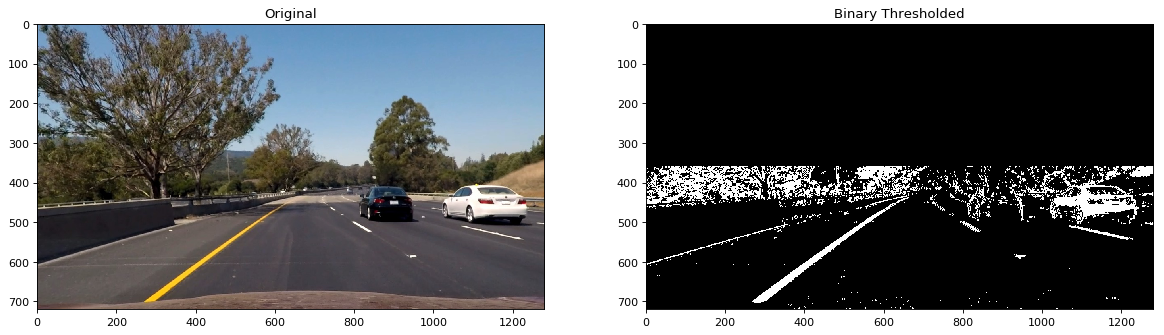

In [185]:
images = glob.glob('./test_images/*.jpg')

for f_name in images:
    img = plt.imread(f_name)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    thresholdedImg = binaryThresholded(undist)
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(1,2,1)
    ax.set_title("Original")
    plt.imshow(undist)

    ax = plt.subplot(1,2,2)
    ax.set_title("Binary Thresholded")
    plt.imshow(thresholdedImg, cmap='gray')

## 4. Apply a perspective transform